# Trabalho 1
---

**Alunos**:
  1. João Gabriel Sasseron Roberto Amorim (12542564)
  2. Bernardo Maia Coelho (12542481)


**Disciplina**: SCC0276 - Aprendizado de Máquina (2024)

**Docente**: Ricador Cerri



# Bibiliotecas utilizadas

---

Na execução deste projeto, empregamos bibliotecas Python que disponibilizam uma ampla gama de funcionalidades essenciais para o pipeline de Aprendizado de máquina, incluindo `scikit-learn`, `numpy` e `pytorch`. Além disso, aproveitamos as diretrizes de visualização gráfica através de bibliotecas como `Matplotlib`.

In [1]:

import os
import glob 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn.functional as F

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, make_scorer
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from itertools import cycle

from tqdm import tqdm
from PIL import Image

warnings.filterwarnings('ignore')

Para a execução de modelos baseados em redes neurais utilizados o `device` cuda para termos um melhore desempenho.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


# Análise exploratória

---

O primeiro passo fundamental para o aprendizado de máquin a é compreender o conjunto de dados que será analisado e processado. Essa etapa envolve a exploração da estrutura, da qualidade e da composição dos dados, o que pode favorecer a aquisição de conhecimento para uma base sólida de análises subsequentes. Ressalte-se que a compreensão abrangente dos dados é essencial para identificar padrões, tendências e insights valiosos, os quais impulsionarão as decisões e descobertas ao longo do projeto. 

## Carregamento do Dataset

In [3]:
path_data = './data' # Diretório das imagens
labels = []
images = []

# Percorre a pasta com as imagens e para cada imagem lemos ela
# e selecionamos o seu label
for folder in glob.glob(os.path.join(path_data, '*')):
    for file in glob.glob(os.path.join(folder, '*')):
        # Adiciona a classe da imagem
        labels.append(folder.replace(f'{path_dathisza}/', ''))
        
        # Adiciona a imagem
        images.append(Image.open(file).convert('RGB'))
        
print(f'Número total de imagens: {len(images)}')

Número total de imagens: 3388


## Visualizalção dos dados

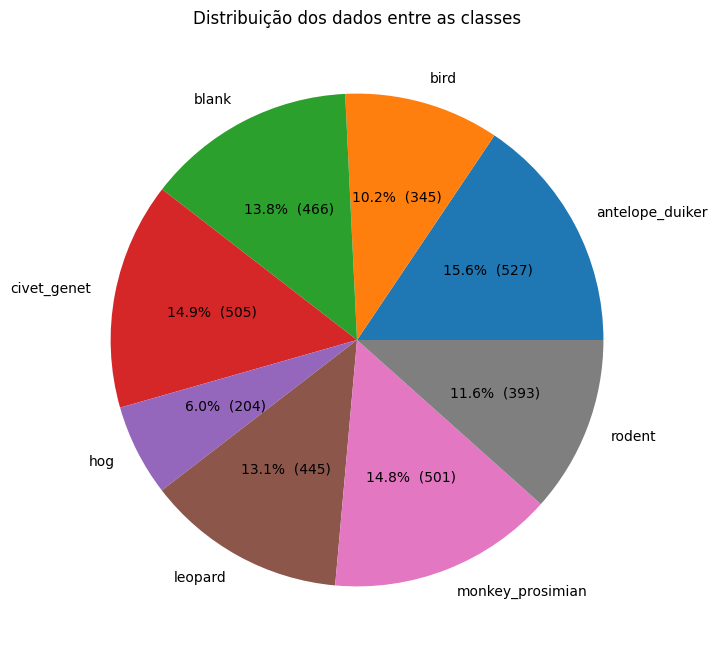

In [4]:
# Valores das classes
unq_labels, count_labels = np.unique(labels, return_counts=True)

plt.figure(figsize=(8, 8))
plt.pie(count_labels, labels=unq_labels, autopct=lambda p: '{:.1f}%  ({:d})'.format(p, int(p/100 * sum(count_labels))))
plt.title('Distribuição dos dados entre as classes')

plt.show()

Com base na imagem acima que mostram a distribuição das classes, podemos perceber que, em sua maioria, o número de classes é balanceado. Apenas a classe `hog` apresenta um número baixo de exemplos. No entanto, decidimos manter a classe `hog` na proporção original para garantir a representatividade e robustez do modelo, evitando distorções nos dados e assegurando que todas as classes sejam corretamente reconhecidas.

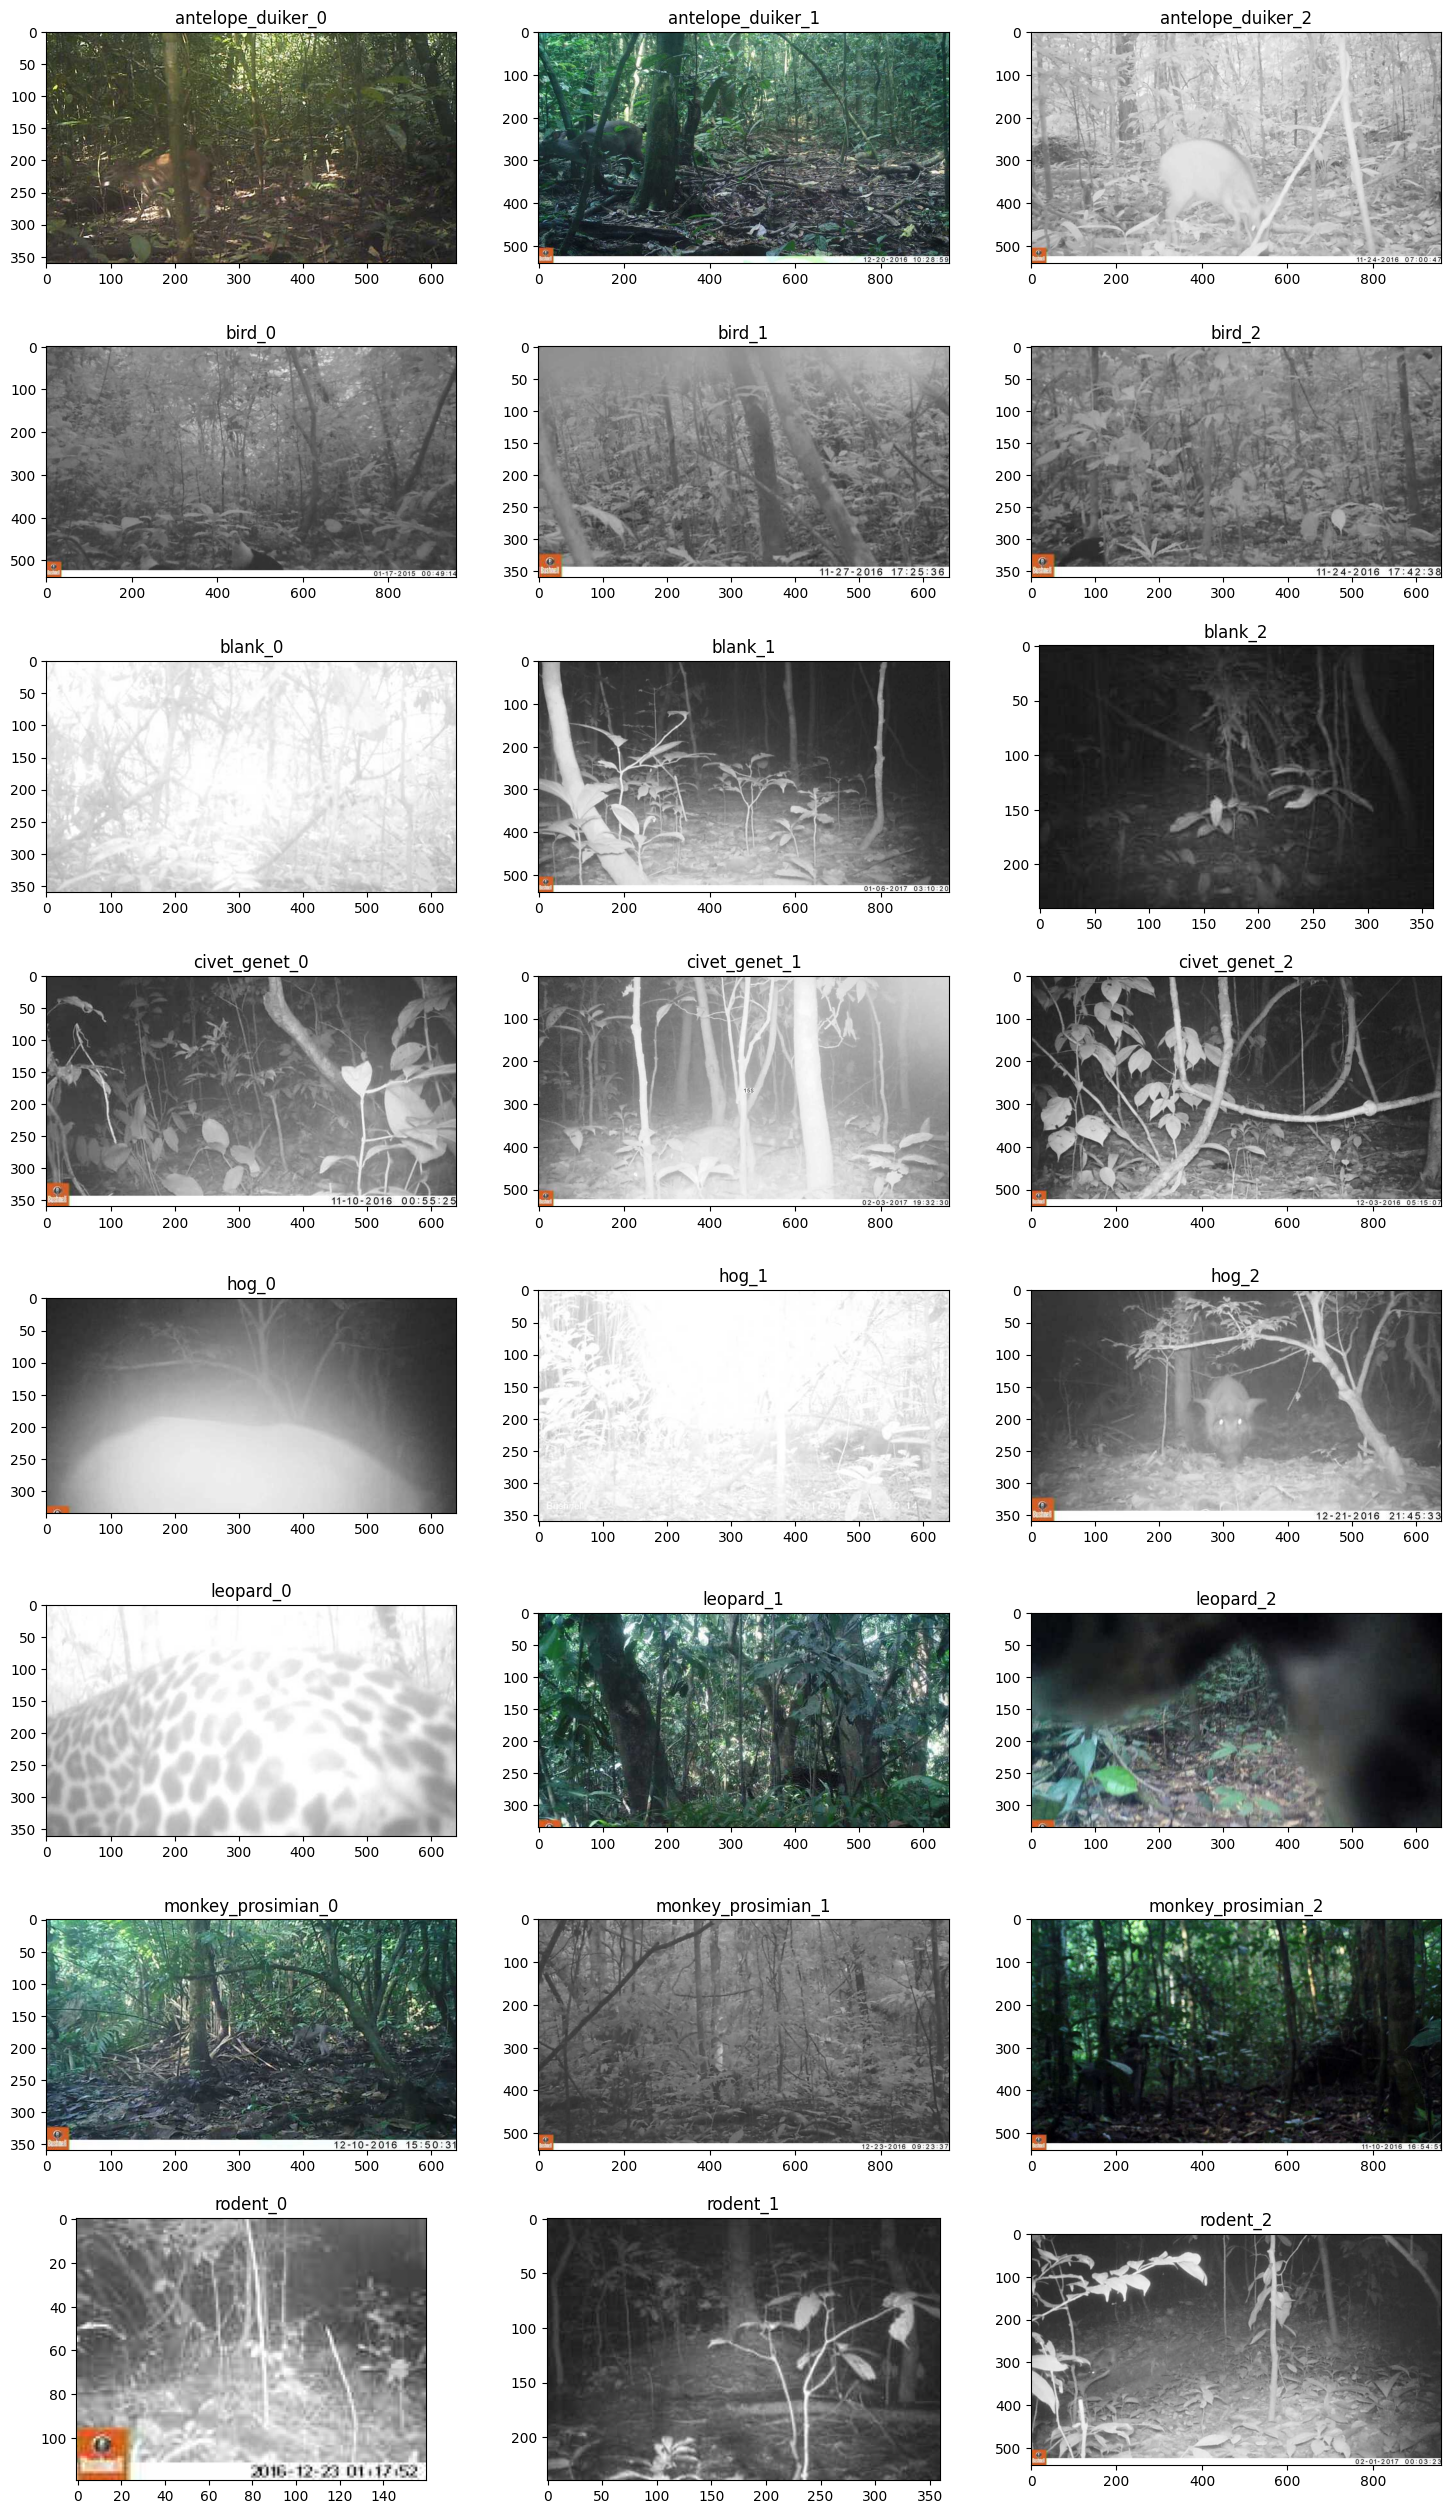

In [5]:
# Dicionário para cada claase
images_by_class = {cls: [] for cls in unq_labels}
for name, img in zip(labels, images):
    images_by_class[name].append(img)

# Plotagens de imagens como exemplo
n_img = 3
n_label = len(unq_labels)
fig, axs = plt.subplots(n_label, n_img, figsize=(18, 4 * n_label))

for i, cls in enumerate(unq_labels):
    for j in range(n_img):  
        axs[i, j].imshow(images_by_class[cls][j])
        axs[i, j].set_title(f'{cls}_{j}')
        
plt.show()

del images_by_class

# Criação do dataset

---

Agora, na segunda etapa, com todos os dados em mãos, vamos ajustá-los para serem compatíveis com os modelos. Dado que os dados originais estão em formato de lista de image.PIL, faremos a transformação deles em inputs válidos para os modelos utilizados.

In [6]:
# Dicionário auxiliar para a label-encoding
to_index = {
        name: index for index, name in enumerate(unq_labels)
    }

# Aplicação do label enconding
labels = np.asarray(list(map(lambda x: to_index[x], labels)))

In [7]:
# Divide os dados entre os conjuntos de treino de teste
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

del images, labels

O primeiro passo é aplicar o label encoding nas classes de classificação, que estão em formato de string, convertendo-as para inteiro. Em seguida, aplicamos com a divisão do dataset em conjuntos de treinamento e teste.

## Funções úteis

In [8]:
def to_classic(x, y):
    """
        Função responsável por receber os dados brutos e transformá-los em entradas 
        e saídas válidas para modelos tradicionais, como Naive Bayes, Árvores de Decisão, entre outros.

        Parâmetros:
            x: lista de imagens
            y: lista de etiquetas
        Retorno:
            images: matriz NumPy redimensionada
            labels: matriz NumPy de etiquetas
    """
    images = []
    labels = []

    for img, label in zip(x, y):
        # Redimensiona todas as imagens e transforma elas em array 1-D numpy
        images.append(np.array(img.resize((32, 32))).flatten())
        labels.append(label)  
    
    # Normalização dos dados
    images = MinMaxScaler().fit_transform(np.array(images))
    labels = np.array(labels)
    
    return images, labels 

In [9]:
class AnimalsData(Dataset):
    """
        Classe responsável pela criação dos dados a serem utilizados em redes neurais criadas com PyTorch.

        Parâmetros:
            x: lista de imagens
            y: lista de etiquetas
            shape: formato para redimensionamento da imagem
    """
    def __init__(self, x, y, shape):
        self.x = x
        self.y = y
        self.transform = transforms.Compose(
            [
                transforms.Resize(shape), # Redimensionalização
                transforms.ToTensor(),    # Converte para tensor 
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )
    
    def __getitem__(self, index):
        img = self.transform(self.x[index])
        label = torch.tensor(self.y[index], dtype=torch.long)
        
        return img, label
    
    def __len__(self):
        return len(self.x)

# Modelos

---

Nesta terceira etapa, vamos definir as arquiteturas que serão empregadas na classificação dos nossos dados. Optamos por utilizar quatro modelos tradicionais de aprendizado de máquina: Naive Bayes, Decision Tree, K-Nearest Neighbors e Random Forest. Para cada um desses modelos, iremos explorar seus melhores parâmetros para obter a melhor classificação possível. Além disso, incorporaremos três modelos robustos de aprendizado profundo: LeNet, um modelo de estado da arte e um modelo de desenvolvimento próprio.

## Clássicos


Os modelos clássicos selecionados para a classificação são:
    
1. **Naive Bayes**: modelo probabilístico simples e eficaz, frequentemente utilizado em tarefas de classificação de texto e categorização de documentos.
2. **Árvore de Decisão**: modelo versátil que permite representar e interpretar regras de decisão de forma intuitiva, sendo útil para problemas de classificação e regressão.
3. **KNN**: modelo de aprendizado 'preguiçoso' que se baseia na proximidade dos dados no espaço de características, sendo adequado para problemas com estrutura complexa e não linear.
4. **Random Forest**: método de conjunto baseado em árvores de decisão, conhecido por sua eficácia em lidar com grandes conjuntos de dados e alta dimensionalidade, além de oferecer boa resistência ao overfitting.

**OBS**: Os métodos SVM e Ridge Classifier, não foram implementados devido a limitações de hardware.

In [10]:
param_grid = {
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': np.logspace(0, -9, num=100)
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 30, 50],
            'min_samples_split': [1, 2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [2, 3, 5],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200, 250],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2]
        }
    }
}

## LeNet5

A LeNet-5 foi criada por Yann LeCun em 1998 para reconhecimento de dígitos em imagens e é uma dos modelos pioneiros para classificação de imagens. A arquitetura da rede é simples, formada por 3 camadas convolucionais, 2 camadas de pooling e 2 camadas totalmente conectadas. Em virtude deste marco histórico, iremos implementatas como benchmark para as redes neurais em nosso projeto.

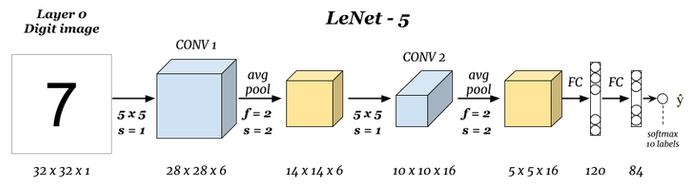

In [11]:
class LeNet5(nn.Module):
	def __init__(self, n_label):
		super().__init__()

		self.conv1 = nn.Conv2d(in_channels=3,
							   out_channels=6,
							   kernel_size=(5,5),
							   padding=2)
		
		self.act1 = nn.Tanh()

		self.pool1 = nn.AvgPool2d(kernel_size=(2,2),
								  stride=2)

		self.conv2 = nn.Conv2d(in_channels=6,
							   out_channels=16,
							   kernel_size=(5,5),
							   padding=2)

		self.act2 = nn.Tanh()

		self.pool2 = nn.AvgPool2d(kernel_size=(2,2),
								  stride=2)

		self.conv3 = nn.Conv2d(in_channels=16,
							   out_channels=120,
							   kernel_size=(8,8),
							   padding=0)

		self.flat = nn.Flatten()
		self.fc1 = nn.Linear(120, 84)
		self.act3 = nn.Sigmoid()
		self.fc2 = nn.Linear(84, n_label)

	def forward(self, x):
		x = self.pool1(self.act1(self.conv1(x)))
		x = self.pool2(self.act2(self.conv2(x)))
		x = self.conv3(x)
		x = self.flat(x)
		x = self.act3(self.fc1(x))
		x = self.fc2(x)

		return x

In [12]:
model = LeNet5(n_label)
model = model.to(device)
summary(model, (3, 32, 32))

del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             456
              Tanh-2            [-1, 6, 32, 32]               0
         AvgPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           2,416
              Tanh-5           [-1, 16, 16, 16]               0
         AvgPool2d-6             [-1, 16, 8, 8]               0
            Conv2d-7            [-1, 120, 1, 1]         123,000
           Flatten-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
          Sigmoid-10                   [-1, 84]               0
           Linear-11                    [-1, 8]             680
Total params: 136,716
Trainable params: 136,716
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

## Custom

Esta arquitetura de CNN foi customizada especificamente para atender às necessidades do nosso projeto, com ajustes realizados com base em experimentação e análise empírica.

In [13]:
class CustomModel(nn.Module):
    def __init__(self, n_label):
        super(CustomModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.dropout = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(18 * 18 * 64, n_label)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        
        return x

In [14]:
model = CustomModel(n_label)
model = model.to(device)
summary(model, (3, 224, 224))

del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          18,496
       BatchNorm2d-5           [-1, 64, 56, 56]             128
         MaxPool2d-6           [-1, 64, 18, 18]               0
           Dropout-7           [-1, 64, 18, 18]               0
           Flatten-8                [-1, 20736]               0
            Linear-9                    [-1, 8]         165,896
Total params: 185,480
Trainable params: 185,480
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 28.80
Params size (MB): 0.71
Estimated Total Size (MB): 30.08
-----------------------------------------

## Artigo

Para investigar o estado da arte em nosso campo de pesquisa, optamos por replicar um artigo publicado na [IEEE](https://ieeexplore.ieee.org/document/7025172) relacionado ao nosso projeto. Nesse estudo, uma CNN é descrita, contendo 3 camadas convolucionais, 3 camadas de max pooling, uma camada totalmente conectada e uma camada softmax. Esta rede opera em imagens de 128x128 pixels, aplicando operações de convolução e pooling para extrair características essenciais antes da classificação final.

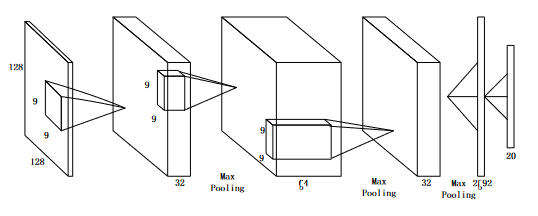

In [15]:
class CNNModel(nn.Module):
    def __init__(self, n_label):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=9)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=9)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=9)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 9 * 9, 256)
        self.fc2 = nn.Linear(256, n_label)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 32 * 9 * 9)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
model = CNNModel(n_label)
model = model.to(device)
summary(model, (3, 128, 128))

del model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 120, 120]           7,808
         MaxPool2d-2           [-1, 32, 60, 60]               0
            Conv2d-3           [-1, 64, 52, 52]         165,952
         MaxPool2d-4           [-1, 64, 26, 26]               0
            Conv2d-5           [-1, 32, 18, 18]         165,920
         MaxPool2d-6             [-1, 32, 9, 9]               0
            Linear-7                  [-1, 256]         663,808
            Linear-8                    [-1, 8]           2,056
Total params: 1,005,544
Trainable params: 1,005,544
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 6.15
Params size (MB): 3.84
Estimated Total Size (MB): 10.17
----------------------------------------------------------------


# Treinamento

---

Nesta quarta etapa deste projeto, estamos prontos para iniciar o treinamento dos modelos que foram previamente estabelecidos. Este estágio marca um ponto crucial no desenvolvimento do projeto, onde colocaremos em prática todas as configurações e arquiteturas definidas anteriormente. Além disso, po treinamento dos modelos é essencial para permitir que aprendam com os dados disponíveis, ajustando seus parâmetros para melhor se adaptar aos padrões e características presentes nos nossos conjuntos de dados. Pro fim, esperamos obter modelos treinados e otimizados, prontos para serem avaliados e utilizados para as tarefas específicas do nosso projeto.

## Funções úteis

In [17]:
class EarlyStop:
    """
        Classe criada com o intuito de evitar o overfitting nas redes neurais, 
        esta classe serve para interromper o treinamento quando 
        um determinado número de épocas passa o limite de perda.
        
        Parâmetros:
            tolerance: número de vezes que será aceito a loss do treino superar 
            a loss da validação.
            delta: intervalor que será atribuido a loss do treinamento.
    """
    def __init__(self, tolerance=5, delta=0.1):
        # Número de vezes que será aceito que a loss de validação
        # seja maior que a do treinamento
        self.tolerance = tolerance 
        self.delta = delta # Estipulção de um limite que aceitados variação
        self.best_val_loss = float('inf')
    
    def stop(self, train_loss, val_loss):
        # Atualização da melhor loss de validação
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
        
        # Checa de a perda da validação foi maior do que a do treino
        if  train_loss + self.delta < self.best_val_loss:
            self.tolerance -= 1
            
            if self.tolerance == 0:
                return True
        return False
            

In [18]:
def get_train_data(model_name, n_label):
    """
        Função responsável por retornar o modelo e o conjunto de dados para o treinamento das redes neurais.
        
        Parâmetros:
            model_name: nome do modelo para obter o conjunto de dados.
            n_label: número de classas.
        Retorno:
            model: modelo carregado
            train_loader: conjunto de dados de treinamento.
            train_teste: conjunto de dados de teste.
    """
    
    model, train_loader, test_loader = None, None, None
    
    match model_name:
        case 'LeNet5':
            model = LeNet5(n_label)
            train_loader = DataLoader(AnimalsData(X_train, y_train, (32, 32)), batch_size=32, shuffle=True, num_workers=3)
            test_loader  = DataLoader(AnimalsData(X_test, y_test, (32, 32)), batch_size=32, shuffle=True, num_workers=3)
        case 'CNN_Custom':
            model = CustomModel(n_label)
            train_loader = DataLoader(AnimalsData(X_train, y_train, (224, 224)), batch_size=32, shuffle=True, num_workers=3)
            test_loader  = DataLoader(AnimalsData(X_test, y_test, (224, 224)), batch_size=32, shuffle=True, num_workers=3)
        case 'CNN_Article':
            model = CNNModel(n_label)
            train_loader = DataLoader(AnimalsData(X_train, y_train, (128, 128)), batch_size=32, shuffle=True, num_workers=3)
            test_loader  = DataLoader(AnimalsData(X_test, y_test, (128, 128)), batch_size=32, shuffle=True, num_workers=3)
    
    if model != None:
        model.to(device)
    
    return model, train_loader, test_loader

In [19]:
def plot_loss(hist_tr, hist_val):
    """
        Função responsável pela plotagem da loss durante o treinamento.
        
        Parâmetros:
            hist_tr: lista de loss de treinamento por época.
            hist_val: lista de loss de validação por época.
    """
    
    plt.figure(figsize = (6,4))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(np.arange(len(hist_tr)), hist_tr, label = 'Train')
    plt.plot(np.arange(len(hist_val)), hist_val, label = 'Validation')
    plt.legend()
    plt.show()

In [22]:
# Execução do treinamento das redes neurais
def trainig(model, train_loader, test_loader, name, early_stop=None, n_epochs=1000):
    """
        A função encarregada do treinamento das redes neurais realiza todas as etapas necessárias, 
        incluindo a propagação direta (forward), retropropagação (backward) e ajuste dos pesos.
        
        Parâmetros:
            model: modelo a ser treinado.
            train_loader: conjunto de dados de treinamento.
            test_loader: conjunto de dados de teste.
            early_stop: classe de early stop configurada.
            name: nome do modelo.
            n_epochs: número de épocas a serem simuladas.
        Retorno:
            hist_tr: lista de valore da loss do treinamento.
            hist_val: lista de valore da loss do teste.
    """
    
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    
    hist_tr = []
    hist_val = []
    hist_acc = []

    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1:3}/{n_epochs:<4}')
        epoch_train_loss = 0
        model.train()  # Garante que o modelo está em modo de treinamento

        for img, label in tqdm(train_loader):
            img, label = img.to(device), label.to(device)
            
            # Forward, backward, ajuste de pesos
            y_hat = model(img)
            loss = loss_fn(y_hat, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += float(loss)
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        hist_tr.append(avg_train_loss)
        
        epoch_val_loss = 0
        correct_predictions = 0
        model.eval()  # Garante que o modelo está em modo de avaliação

        with torch.no_grad():
            for img, label in test_loader:
                img, label = img.to(device), label.to(device)
                
                y_hat = model(img)
                loss = loss_fn(y_hat, label)
                
                epoch_val_loss += float(loss)
                correct_predictions += (torch.argmax(y_hat, dim=1) == label).sum().item()
        
        avg_val_loss = epoch_val_loss / len(test_loader)
        accuracy = correct_predictions / len(test_loader.dataset)
        
        hist_val.append(avg_val_loss)
        hist_acc.append(accuracy)
        
        print(f'train loss: {avg_train_loss:.3f} - validation loss: {avg_val_loss:.3f} - acc: {accuracy:.3f}\n')
        
        # Early stopping
        if early_stop != None and early_stop.stop(avg_train_loss, avg_val_loss):
            print('Early stop')
            torch.save(model, f'./models/model_{name}.pth')
            return hist_tr, hist_val
        
    torch.save(model, f'./models/model_{name}.pth')
    return hist_tr, hist_val

## Clássicos

Para o treinamento do conjunto de arquitetura clássicos utilizamos o método disponibilizado pelo `GridSearchCV`, que, combinado com o `K-Fold`, permite explorar os dados de treinamento por meio do `sistema de rotação e validação`. Assim, os dados de treinamento serão repartidos em 5 conjuntos, sendo certo que 4 (quatro) deles serão de treinamento e o último reservado validação. Posteriormente, esses conjuntos de dados serão rotacionados, permitindo um treinamento mais eficiente. Com isso, poderemos selecionar os melhores parâmetros para cada arquetira. Deste modo, com os melhores parâmetros iremos treinar o modelo com todo o conjunto de dados de treinamento.

In [21]:
X_train_classic, y_train_classic = to_classic(X_train, y_train)
X_test_classic, y_test_classic = to_classic(X_test, y_test)

best_classifiers = {}
best_scores = {}

# Configura e executa o GridSearchCV
for name, clf_info in param_grid.items():
    grid_search = GridSearchCV(clf_info['model'], clf_info['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_classic, y_train_classic)

    print(f'Melhores parâmetros {name}: {grid_search.best_params_}')
    print(f'Melhor desempenho para cross-validation {name}: {grid_search.best_score_}')
    
    best_model = grid_search.best_estimator_
    best_model.set_params(**grid_search.best_params_)
    best_model.fit(X_train_classic, y_train_classic)

    joblib.dump(best_model, f'./models/model_{name.replace(" ", "_")}.joblib')
    print(f'Salvando modelo {name} \n\n')
    
del X_train_classic, y_train_classic, X_test_classic, y_test_classic

Melhores parâmetros Naive Bayes: {'var_smoothing': 0.12328467394420659}
Melhor desempenho para cross-validation Naive Bayes: 0.2870848708487085
Salvando modelo Naive Bayes 


Melhores parâmetros Decision Tree: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor desempenho para cross-validation Decision Tree: 0.5391143911439114
Salvando modelo Decision Tree 


Melhores parâmetros K-Nearest Neighbors: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Melhor desempenho para cross-validation K-Nearest Neighbors: 0.6453874538745387
Salvando modelo K-Nearest Neighbors 


Melhores parâmetros Random Forest: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Melhor desempenho para cross-validation Random Forest: 0.655350553505535
Salvando modelo Random Forest 




Observando os dados acima, percebemos que o melhor modelo foi a `Random Forest com` os parâmetros `{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}`, alcançando uma acurácia de $0.655350553505535$. Além disso, optamos pela acurácia no k-fold cross-validation devido à sua capacidade de fornecer uma avaliação abrangente do desempenho do modelo em diferentes conjuntos de dados. No entanto, é importante considerar outras métricas além da acurácia serão consideradas para a avaliação final.

## LeNet5

Para o treinamento das redes neurais, optamos por não usar k-fold cross-validation, mas sim treinar com o dataset inteiro para maximizar o uso dos dados. Com o intuito de permitir que o modelo aproveite a totalidade dos dados disponíveis para aprendizado, maximizando a quantidade de informação utilizada para ajuste dos parâmetros. Além disso, implementamos early stopping nos modelos sem dropout para evitar overfitting, interrompendo o treinamento quando o desempenho no conjunto de validação começa a piorar.

In [56]:
model, train_loader, test_loader = get_train_data('LeNet5', n_label)
early_stop = EarlyStop(tolerance=10, delta=0.1)

hist_tr, hist_val = trainig(model, train_loader, test_loader, 'LeNet5', early_stop)

Epoch   1/1000


100%|██████████| 85/85 [00:01<00:00, 63.97it/s]


train loss: 2.080 - validation loss: 2.047 - acc: 0.192

Epoch   2/1000


100%|██████████| 85/85 [00:01<00:00, 68.83it/s]


train loss: 2.045 - validation loss: 2.036 - acc: 0.236

Epoch   3/1000


100%|██████████| 85/85 [00:01<00:00, 67.20it/s]


train loss: 2.039 - validation loss: 2.029 - acc: 0.271

Epoch   4/1000


100%|██████████| 85/85 [00:01<00:00, 68.61it/s]


train loss: 2.031 - validation loss: 2.022 - acc: 0.263

Epoch   5/1000


100%|██████████| 85/85 [00:01<00:00, 65.58it/s]


train loss: 2.017 - validation loss: 2.003 - acc: 0.248

Epoch   6/1000


100%|██████████| 85/85 [00:01<00:00, 64.38it/s]


train loss: 1.993 - validation loss: 1.977 - acc: 0.263

Epoch   7/1000


100%|██████████| 85/85 [00:01<00:00, 70.54it/s]


train loss: 1.956 - validation loss: 1.932 - acc: 0.261

Epoch   8/1000


100%|██████████| 85/85 [00:01<00:00, 69.56it/s]


train loss: 1.912 - validation loss: 1.889 - acc: 0.267

Epoch   9/1000


100%|██████████| 85/85 [00:01<00:00, 67.26it/s]


train loss: 1.873 - validation loss: 1.851 - acc: 0.279

Epoch  10/1000


100%|██████████| 85/85 [00:01<00:00, 67.93it/s]


train loss: 1.844 - validation loss: 1.844 - acc: 0.288

Epoch  11/1000


100%|██████████| 85/85 [00:01<00:00, 64.62it/s]


train loss: 1.825 - validation loss: 1.815 - acc: 0.298

Epoch  12/1000


100%|██████████| 85/85 [00:01<00:00, 63.19it/s]


train loss: 1.810 - validation loss: 1.800 - acc: 0.292

Epoch  13/1000


100%|██████████| 85/85 [00:01<00:00, 60.66it/s]


train loss: 1.799 - validation loss: 1.789 - acc: 0.298

Epoch  14/1000


100%|██████████| 85/85 [00:01<00:00, 56.76it/s]


train loss: 1.791 - validation loss: 1.792 - acc: 0.289

Epoch  15/1000


100%|██████████| 85/85 [00:01<00:00, 67.17it/s]


train loss: 1.784 - validation loss: 1.789 - acc: 0.302

Epoch  16/1000


100%|██████████| 85/85 [00:01<00:00, 69.03it/s]


train loss: 1.777 - validation loss: 1.783 - acc: 0.308

Epoch  17/1000


100%|██████████| 85/85 [00:01<00:00, 65.70it/s]


train loss: 1.771 - validation loss: 1.778 - acc: 0.301

Epoch  18/1000


100%|██████████| 85/85 [00:01<00:00, 69.02it/s]


train loss: 1.766 - validation loss: 1.771 - acc: 0.305

Epoch  19/1000


100%|██████████| 85/85 [00:01<00:00, 70.47it/s]


train loss: 1.758 - validation loss: 1.762 - acc: 0.301

Epoch  20/1000


100%|██████████| 85/85 [00:01<00:00, 67.58it/s]


train loss: 1.752 - validation loss: 1.753 - acc: 0.311

Epoch  21/1000


100%|██████████| 85/85 [00:01<00:00, 67.84it/s]


train loss: 1.747 - validation loss: 1.749 - acc: 0.304

Epoch  22/1000


100%|██████████| 85/85 [00:01<00:00, 69.27it/s]


train loss: 1.741 - validation loss: 1.726 - acc: 0.327

Epoch  23/1000


100%|██████████| 85/85 [00:01<00:00, 68.15it/s]


train loss: 1.735 - validation loss: 1.730 - acc: 0.313

Epoch  24/1000


100%|██████████| 85/85 [00:01<00:00, 71.32it/s]


train loss: 1.729 - validation loss: 1.727 - acc: 0.323

Epoch  25/1000


100%|██████████| 85/85 [00:01<00:00, 70.34it/s]


train loss: 1.723 - validation loss: 1.724 - acc: 0.316

Epoch  26/1000


100%|██████████| 85/85 [00:01<00:00, 70.92it/s]


train loss: 1.718 - validation loss: 1.719 - acc: 0.323

Epoch  27/1000


100%|██████████| 85/85 [00:01<00:00, 71.73it/s]


train loss: 1.712 - validation loss: 1.714 - acc: 0.322

Epoch  28/1000


100%|██████████| 85/85 [00:01<00:00, 70.41it/s]


train loss: 1.705 - validation loss: 1.691 - acc: 0.322

Epoch  29/1000


100%|██████████| 85/85 [00:01<00:00, 70.99it/s]


train loss: 1.700 - validation loss: 1.702 - acc: 0.323

Epoch  30/1000


100%|██████████| 85/85 [00:01<00:00, 71.36it/s]


train loss: 1.693 - validation loss: 1.676 - acc: 0.323

Epoch  31/1000


100%|██████████| 85/85 [00:01<00:00, 71.59it/s]


train loss: 1.686 - validation loss: 1.688 - acc: 0.333

Epoch  32/1000


100%|██████████| 85/85 [00:01<00:00, 71.66it/s]


train loss: 1.680 - validation loss: 1.670 - acc: 0.329

Epoch  33/1000


100%|██████████| 85/85 [00:01<00:00, 70.90it/s]


train loss: 1.670 - validation loss: 1.686 - acc: 0.341

Epoch  34/1000


100%|██████████| 85/85 [00:01<00:00, 70.36it/s]


train loss: 1.665 - validation loss: 1.666 - acc: 0.333

Epoch  35/1000


100%|██████████| 85/85 [00:01<00:00, 70.85it/s]


train loss: 1.658 - validation loss: 1.653 - acc: 0.336

Epoch  36/1000


100%|██████████| 85/85 [00:01<00:00, 71.09it/s]


train loss: 1.651 - validation loss: 1.661 - acc: 0.339

Epoch  37/1000


100%|██████████| 85/85 [00:01<00:00, 68.80it/s]


train loss: 1.644 - validation loss: 1.649 - acc: 0.355

Epoch  38/1000


100%|██████████| 85/85 [00:01<00:00, 70.03it/s]


train loss: 1.638 - validation loss: 1.642 - acc: 0.361

Epoch  39/1000


100%|██████████| 85/85 [00:01<00:00, 69.74it/s]


train loss: 1.635 - validation loss: 1.639 - acc: 0.372

Epoch  40/1000


100%|██████████| 85/85 [00:01<00:00, 67.70it/s]


train loss: 1.629 - validation loss: 1.614 - acc: 0.350

Epoch  41/1000


100%|██████████| 85/85 [00:01<00:00, 67.34it/s]


train loss: 1.624 - validation loss: 1.618 - acc: 0.335

Epoch  42/1000


100%|██████████| 85/85 [00:01<00:00, 70.91it/s]


train loss: 1.620 - validation loss: 1.626 - acc: 0.358

Epoch  43/1000


100%|██████████| 85/85 [00:01<00:00, 70.82it/s]


train loss: 1.615 - validation loss: 1.624 - acc: 0.361

Epoch  44/1000


100%|██████████| 85/85 [00:01<00:00, 70.50it/s]


train loss: 1.614 - validation loss: 1.605 - acc: 0.372

Epoch  45/1000


100%|██████████| 85/85 [00:01<00:00, 69.54it/s]


train loss: 1.609 - validation loss: 1.589 - acc: 0.373

Epoch  46/1000


100%|██████████| 85/85 [00:01<00:00, 60.90it/s]


train loss: 1.606 - validation loss: 1.610 - acc: 0.373

Epoch  47/1000


100%|██████████| 85/85 [00:01<00:00, 57.04it/s]


train loss: 1.601 - validation loss: 1.602 - acc: 0.378

Epoch  48/1000


100%|██████████| 85/85 [00:01<00:00, 63.91it/s]


train loss: 1.600 - validation loss: 1.608 - acc: 0.369

Epoch  49/1000


100%|██████████| 85/85 [00:01<00:00, 67.27it/s]


train loss: 1.596 - validation loss: 1.612 - acc: 0.379

Epoch  50/1000


100%|██████████| 85/85 [00:01<00:00, 66.27it/s]


train loss: 1.591 - validation loss: 1.603 - acc: 0.372

Epoch  51/1000


100%|██████████| 85/85 [00:01<00:00, 68.45it/s]


train loss: 1.586 - validation loss: 1.587 - acc: 0.401

Epoch  52/1000


100%|██████████| 85/85 [00:01<00:00, 69.77it/s]


train loss: 1.584 - validation loss: 1.568 - acc: 0.383

Epoch  53/1000


100%|██████████| 85/85 [00:01<00:00, 69.23it/s]


train loss: 1.580 - validation loss: 1.593 - acc: 0.363

Epoch  54/1000


100%|██████████| 85/85 [00:01<00:00, 72.08it/s]


train loss: 1.577 - validation loss: 1.575 - acc: 0.383

Epoch  55/1000


100%|██████████| 85/85 [00:01<00:00, 67.45it/s]


train loss: 1.574 - validation loss: 1.599 - acc: 0.388

Epoch  56/1000


100%|██████████| 85/85 [00:01<00:00, 69.02it/s]


train loss: 1.571 - validation loss: 1.558 - acc: 0.394

Epoch  57/1000


100%|██████████| 85/85 [00:01<00:00, 68.90it/s]


train loss: 1.566 - validation loss: 1.572 - acc: 0.389

Epoch  58/1000


100%|██████████| 85/85 [00:01<00:00, 69.40it/s]


train loss: 1.565 - validation loss: 1.578 - acc: 0.391

Epoch  59/1000


100%|██████████| 85/85 [00:01<00:00, 65.56it/s]


train loss: 1.561 - validation loss: 1.565 - acc: 0.385

Epoch  60/1000


100%|██████████| 85/85 [00:01<00:00, 67.78it/s]


train loss: 1.557 - validation loss: 1.564 - acc: 0.397

Epoch  61/1000


100%|██████████| 85/85 [00:01<00:00, 67.83it/s]


train loss: 1.552 - validation loss: 1.595 - acc: 0.363

Epoch  62/1000


100%|██████████| 85/85 [00:01<00:00, 68.22it/s]


train loss: 1.551 - validation loss: 1.548 - acc: 0.401

Epoch  63/1000


100%|██████████| 85/85 [00:01<00:00, 68.62it/s]


train loss: 1.546 - validation loss: 1.562 - acc: 0.386

Epoch  64/1000


100%|██████████| 85/85 [00:01<00:00, 69.18it/s]


train loss: 1.545 - validation loss: 1.546 - acc: 0.385

Epoch  65/1000


100%|██████████| 85/85 [00:01<00:00, 69.41it/s]


train loss: 1.539 - validation loss: 1.541 - acc: 0.404

Epoch  66/1000


100%|██████████| 85/85 [00:01<00:00, 65.66it/s]


train loss: 1.538 - validation loss: 1.542 - acc: 0.403

Epoch  67/1000


100%|██████████| 85/85 [00:01<00:00, 66.48it/s]


train loss: 1.535 - validation loss: 1.546 - acc: 0.398

Epoch  68/1000


100%|██████████| 85/85 [00:01<00:00, 66.92it/s]


train loss: 1.530 - validation loss: 1.566 - acc: 0.406

Epoch  69/1000


100%|██████████| 85/85 [00:01<00:00, 68.76it/s]


train loss: 1.525 - validation loss: 1.538 - acc: 0.403

Epoch  70/1000


100%|██████████| 85/85 [00:01<00:00, 69.91it/s]


train loss: 1.526 - validation loss: 1.574 - acc: 0.395

Epoch  71/1000


100%|██████████| 85/85 [00:01<00:00, 61.38it/s]


train loss: 1.519 - validation loss: 1.573 - acc: 0.397

Epoch  72/1000


100%|██████████| 85/85 [00:01<00:00, 67.67it/s]


train loss: 1.519 - validation loss: 1.525 - acc: 0.388

Epoch  73/1000


100%|██████████| 85/85 [00:01<00:00, 65.44it/s]


train loss: 1.516 - validation loss: 1.542 - acc: 0.397

Epoch  74/1000


100%|██████████| 85/85 [00:01<00:00, 60.25it/s]


train loss: 1.509 - validation loss: 1.542 - acc: 0.394

Epoch  75/1000


100%|██████████| 85/85 [00:01<00:00, 59.30it/s]


train loss: 1.508 - validation loss: 1.522 - acc: 0.412

Epoch  76/1000


100%|██████████| 85/85 [00:01<00:00, 64.57it/s]


train loss: 1.505 - validation loss: 1.517 - acc: 0.398

Epoch  77/1000


100%|██████████| 85/85 [00:01<00:00, 68.79it/s]


train loss: 1.502 - validation loss: 1.518 - acc: 0.388

Epoch  78/1000


100%|██████████| 85/85 [00:01<00:00, 67.85it/s]


train loss: 1.498 - validation loss: 1.525 - acc: 0.391

Epoch  79/1000


100%|██████████| 85/85 [00:01<00:00, 67.06it/s]


train loss: 1.494 - validation loss: 1.525 - acc: 0.407

Epoch  80/1000


100%|██████████| 85/85 [00:01<00:00, 69.46it/s]


train loss: 1.493 - validation loss: 1.493 - acc: 0.400

Epoch  81/1000


100%|██████████| 85/85 [00:01<00:00, 69.91it/s]


train loss: 1.490 - validation loss: 1.501 - acc: 0.407

Epoch  82/1000


100%|██████████| 85/85 [00:01<00:00, 68.87it/s]


train loss: 1.486 - validation loss: 1.528 - acc: 0.392

Epoch  83/1000


100%|██████████| 85/85 [00:01<00:00, 71.66it/s]


train loss: 1.482 - validation loss: 1.515 - acc: 0.410

Epoch  84/1000


100%|██████████| 85/85 [00:01<00:00, 69.48it/s]


train loss: 1.479 - validation loss: 1.525 - acc: 0.391

Epoch  85/1000


100%|██████████| 85/85 [00:01<00:00, 63.89it/s]


train loss: 1.476 - validation loss: 1.528 - acc: 0.391

Epoch  86/1000


100%|██████████| 85/85 [00:01<00:00, 68.60it/s]


train loss: 1.474 - validation loss: 1.494 - acc: 0.386

Epoch  87/1000


100%|██████████| 85/85 [00:01<00:00, 69.21it/s]


train loss: 1.469 - validation loss: 1.487 - acc: 0.394

Epoch  88/1000


100%|██████████| 85/85 [00:01<00:00, 69.55it/s]


train loss: 1.465 - validation loss: 1.515 - acc: 0.400

Epoch  89/1000


100%|██████████| 85/85 [00:01<00:00, 66.56it/s]


train loss: 1.463 - validation loss: 1.486 - acc: 0.409

Epoch  90/1000


100%|██████████| 85/85 [00:01<00:00, 67.05it/s]


train loss: 1.461 - validation loss: 1.505 - acc: 0.404

Epoch  91/1000


100%|██████████| 85/85 [00:01<00:00, 62.66it/s]


train loss: 1.456 - validation loss: 1.529 - acc: 0.391

Epoch  92/1000


100%|██████████| 85/85 [00:01<00:00, 55.75it/s]


train loss: 1.454 - validation loss: 1.484 - acc: 0.406

Epoch  93/1000


100%|██████████| 85/85 [00:01<00:00, 56.60it/s]


train loss: 1.449 - validation loss: 1.481 - acc: 0.417

Epoch  94/1000


100%|██████████| 85/85 [00:01<00:00, 64.82it/s]


train loss: 1.444 - validation loss: 1.489 - acc: 0.410

Epoch  95/1000


100%|██████████| 85/85 [00:01<00:00, 70.23it/s]


train loss: 1.441 - validation loss: 1.470 - acc: 0.416

Epoch  96/1000


100%|██████████| 85/85 [00:01<00:00, 52.88it/s]


train loss: 1.435 - validation loss: 1.486 - acc: 0.412

Epoch  97/1000


100%|██████████| 85/85 [00:01<00:00, 64.89it/s]


train loss: 1.436 - validation loss: 1.504 - acc: 0.407

Epoch  98/1000


100%|██████████| 85/85 [00:01<00:00, 58.61it/s]


train loss: 1.428 - validation loss: 1.467 - acc: 0.419

Epoch  99/1000


100%|██████████| 85/85 [00:01<00:00, 60.56it/s]


train loss: 1.427 - validation loss: 1.461 - acc: 0.417

Epoch 100/1000


100%|██████████| 85/85 [00:01<00:00, 58.96it/s]


train loss: 1.423 - validation loss: 1.505 - acc: 0.401

Epoch 101/1000


100%|██████████| 85/85 [00:01<00:00, 64.66it/s]


train loss: 1.420 - validation loss: 1.461 - acc: 0.419

Epoch 102/1000


100%|██████████| 85/85 [00:01<00:00, 64.82it/s]


train loss: 1.415 - validation loss: 1.467 - acc: 0.422

Epoch 103/1000


100%|██████████| 85/85 [00:01<00:00, 56.50it/s]


train loss: 1.410 - validation loss: 1.474 - acc: 0.413

Epoch 104/1000


100%|██████████| 85/85 [00:01<00:00, 61.30it/s]


train loss: 1.409 - validation loss: 1.472 - acc: 0.428

Epoch 105/1000


100%|██████████| 85/85 [00:01<00:00, 59.54it/s]


train loss: 1.405 - validation loss: 1.433 - acc: 0.437

Epoch 106/1000


100%|██████████| 85/85 [00:01<00:00, 61.40it/s]


train loss: 1.400 - validation loss: 1.464 - acc: 0.407

Epoch 107/1000


100%|██████████| 85/85 [00:01<00:00, 66.86it/s]


train loss: 1.396 - validation loss: 1.446 - acc: 0.441

Epoch 108/1000


100%|██████████| 85/85 [00:01<00:00, 63.77it/s]


train loss: 1.391 - validation loss: 1.475 - acc: 0.429

Epoch 109/1000


100%|██████████| 85/85 [00:01<00:00, 65.24it/s]


train loss: 1.385 - validation loss: 1.452 - acc: 0.425

Epoch 110/1000


100%|██████████| 85/85 [00:01<00:00, 65.24it/s]


train loss: 1.383 - validation loss: 1.460 - acc: 0.429

Epoch 111/1000


100%|██████████| 85/85 [00:01<00:00, 60.93it/s]


train loss: 1.381 - validation loss: 1.433 - acc: 0.435

Epoch 112/1000


100%|██████████| 85/85 [00:01<00:00, 63.60it/s]


train loss: 1.374 - validation loss: 1.461 - acc: 0.426

Epoch 113/1000


100%|██████████| 85/85 [00:01<00:00, 61.02it/s]


train loss: 1.371 - validation loss: 1.451 - acc: 0.432

Epoch 114/1000


100%|██████████| 85/85 [00:01<00:00, 64.74it/s]


train loss: 1.367 - validation loss: 1.433 - acc: 0.428

Epoch 115/1000


100%|██████████| 85/85 [00:01<00:00, 63.08it/s]


train loss: 1.365 - validation loss: 1.458 - acc: 0.434

Epoch 116/1000


100%|██████████| 85/85 [00:01<00:00, 63.27it/s]


train loss: 1.359 - validation loss: 1.446 - acc: 0.444

Epoch 117/1000


100%|██████████| 85/85 [00:01<00:00, 63.60it/s]


train loss: 1.353 - validation loss: 1.455 - acc: 0.438

Epoch 118/1000


100%|██████████| 85/85 [00:01<00:00, 61.57it/s]


train loss: 1.348 - validation loss: 1.401 - acc: 0.457

Epoch 119/1000


100%|██████████| 85/85 [00:01<00:00, 63.66it/s]


train loss: 1.344 - validation loss: 1.444 - acc: 0.447

Epoch 120/1000


100%|██████████| 85/85 [00:01<00:00, 63.13it/s]


train loss: 1.338 - validation loss: 1.441 - acc: 0.444

Epoch 121/1000


100%|██████████| 85/85 [00:01<00:00, 67.43it/s]


train loss: 1.335 - validation loss: 1.408 - acc: 0.466

Epoch 122/1000


100%|██████████| 85/85 [00:01<00:00, 56.26it/s]


train loss: 1.329 - validation loss: 1.415 - acc: 0.456

Epoch 123/1000


100%|██████████| 85/85 [00:01<00:00, 65.97it/s]


train loss: 1.326 - validation loss: 1.401 - acc: 0.456

Epoch 124/1000


100%|██████████| 85/85 [00:01<00:00, 65.94it/s]


train loss: 1.319 - validation loss: 1.445 - acc: 0.442

Epoch 125/1000


100%|██████████| 85/85 [00:01<00:00, 64.20it/s]


train loss: 1.317 - validation loss: 1.408 - acc: 0.450

Epoch 126/1000


100%|██████████| 85/85 [00:01<00:00, 66.72it/s]


train loss: 1.310 - validation loss: 1.410 - acc: 0.454

Epoch 127/1000


100%|██████████| 85/85 [00:01<00:00, 68.36it/s]


train loss: 1.307 - validation loss: 1.397 - acc: 0.456

Epoch 128/1000


100%|██████████| 85/85 [00:01<00:00, 68.87it/s]


train loss: 1.300 - validation loss: 1.385 - acc: 0.469

Epoch 129/1000


100%|██████████| 85/85 [00:01<00:00, 67.79it/s]


train loss: 1.297 - validation loss: 1.386 - acc: 0.466

Epoch 130/1000


100%|██████████| 85/85 [00:01<00:00, 69.44it/s]


train loss: 1.289 - validation loss: 1.430 - acc: 0.451

Epoch 131/1000


100%|██████████| 85/85 [00:01<00:00, 68.48it/s]


train loss: 1.284 - validation loss: 1.384 - acc: 0.457

Epoch 132/1000


100%|██████████| 85/85 [00:01<00:00, 69.72it/s]


train loss: 1.280 - validation loss: 1.386 - acc: 0.481

Epoch 133/1000


100%|██████████| 85/85 [00:01<00:00, 65.89it/s]


train loss: 1.274 - validation loss: 1.397 - acc: 0.473

Epoch 134/1000


100%|██████████| 85/85 [00:01<00:00, 68.06it/s]


train loss: 1.268 - validation loss: 1.378 - acc: 0.484

Epoch 135/1000


100%|██████████| 85/85 [00:01<00:00, 67.84it/s]


train loss: 1.266 - validation loss: 1.360 - acc: 0.479

Epoch 136/1000


100%|██████████| 85/85 [00:01<00:00, 67.14it/s]


train loss: 1.260 - validation loss: 1.372 - acc: 0.472

Epoch 137/1000


100%|██████████| 85/85 [00:01<00:00, 61.53it/s]


train loss: 1.256 - validation loss: 1.380 - acc: 0.488

Epoch 138/1000


100%|██████████| 85/85 [00:01<00:00, 61.43it/s]


train loss: 1.248 - validation loss: 1.368 - acc: 0.476

Epoch 139/1000


100%|██████████| 85/85 [00:01<00:00, 63.23it/s]


train loss: 1.242 - validation loss: 1.365 - acc: 0.485

Epoch 140/1000


100%|██████████| 85/85 [00:01<00:00, 62.31it/s]


train loss: 1.238 - validation loss: 1.349 - acc: 0.484

Epoch 141/1000


100%|██████████| 85/85 [00:01<00:00, 66.84it/s]


train loss: 1.231 - validation loss: 1.343 - acc: 0.475

Epoch 142/1000


100%|██████████| 85/85 [00:01<00:00, 64.38it/s]


train loss: 1.227 - validation loss: 1.371 - acc: 0.497

Early stop


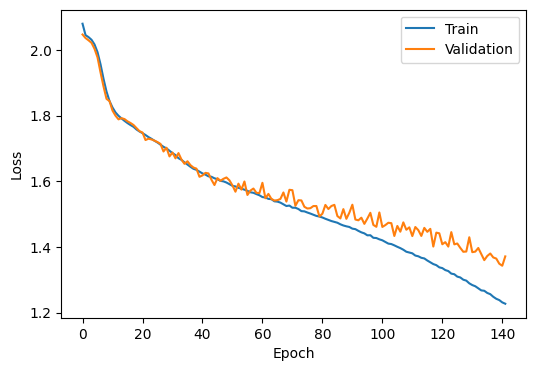

In [57]:
plot_loss(hist_tr, hist_val)

del model, train_loader, test_loader, hist_tr, hist_val

Pela análise do gráfico de loss de treinamento e validação, podemos perceber o funcionamento do early stopping. Assim que a loss de validação começou a aumentar, indicando um potencial overfitting, o treinamento foi interrompido para preservar a capacidade de generalização do modelo.

## Custom

Como o modelo customizado possui dropout como uma de suas características, não implementamos o early stopping. Pois, o dropout ajuda a reduzir o overfitting ao desligar aleatoriamente uma proporção de neurônios durante o treinamento, deste modo forçando o modelo a aprender características mais robustas e não depender excessivamente de neurônios específicos. Isso proporciona uma  melhora na capacidade de generalização do modelo, tornando-o menos propenso a se ajustar demais aos dados de treinamento.

In [23]:
model, train_loader, test_loader = get_train_data('CNN_Custom', n_label)
early_stop = EarlyStop(tolerance=12, delta=0.1)

hist_tr, hist_val = trainig(model, train_loader, test_loader, 'CNN_Custom', early_stop)

Epoch   1/1000


  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:04<00:00, 17.56it/s]


train loss: 9.729 - validation loss: 8.748 - acc: 0.264

Epoch   2/1000


100%|██████████| 85/85 [00:04<00:00, 19.35it/s]


train loss: 3.441 - validation loss: 2.188 - acc: 0.460

Epoch   3/1000


100%|██████████| 85/85 [00:04<00:00, 19.49it/s]


train loss: 1.854 - validation loss: 1.508 - acc: 0.556

Epoch   4/1000


100%|██████████| 85/85 [00:04<00:00, 17.44it/s]


train loss: 1.424 - validation loss: 1.474 - acc: 0.560

Epoch   5/1000


100%|██████████| 85/85 [00:04<00:00, 18.09it/s]


train loss: 1.227 - validation loss: 1.334 - acc: 0.575

Epoch   6/1000


100%|██████████| 85/85 [00:04<00:00, 18.11it/s]


train loss: 1.164 - validation loss: 1.378 - acc: 0.581

Epoch   7/1000


100%|██████████| 85/85 [00:04<00:00, 18.23it/s]


train loss: 0.927 - validation loss: 1.498 - acc: 0.584

Epoch   8/1000


100%|██████████| 85/85 [00:04<00:00, 18.22it/s]


train loss: 0.861 - validation loss: 1.275 - acc: 0.636

Epoch   9/1000


100%|██████████| 85/85 [00:04<00:00, 18.23it/s]


train loss: 0.782 - validation loss: 1.308 - acc: 0.630

Epoch  10/1000


100%|██████████| 85/85 [00:04<00:00, 18.17it/s]


train loss: 0.715 - validation loss: 1.279 - acc: 0.634

Epoch  11/1000


100%|██████████| 85/85 [00:04<00:00, 18.16it/s]


train loss: 0.681 - validation loss: 1.183 - acc: 0.653

Epoch  12/1000


100%|██████████| 85/85 [00:04<00:00, 18.08it/s]


train loss: 0.629 - validation loss: 1.542 - acc: 0.599

Epoch  13/1000


100%|██████████| 85/85 [00:04<00:00, 18.12it/s]


train loss: 0.576 - validation loss: 1.252 - acc: 0.639

Epoch  14/1000


100%|██████████| 85/85 [00:04<00:00, 18.04it/s]


train loss: 0.583 - validation loss: 1.241 - acc: 0.642

Epoch  15/1000


100%|██████████| 85/85 [00:04<00:00, 17.60it/s]


train loss: 0.505 - validation loss: 1.147 - acc: 0.693

Epoch  16/1000


100%|██████████| 85/85 [00:04<00:00, 17.92it/s]


train loss: 0.484 - validation loss: 1.231 - acc: 0.676

Early stop


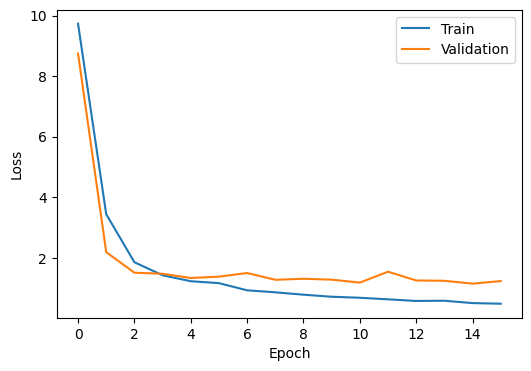

In [24]:
plot_loss(hist_tr, hist_val)

del model, train_loader, test_loader, hist_tr, hist_val

## Artigo

Por fim, para alinhar com o estado da arte, optamos por testar uma arquitetura presente na IEEE, adicionando a técnica de early stopping.

In [ ]:
model, train_loader, test_loader = get_train_data('CNN_Article', n_label)

hist_tr, hist_val = trainig(model, train_loader, test_loader, 'CNN_Article', n_epochs=15)

Epoch   1/15  


  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 85/85 [00:03<00:00, 28.20it/s]


train loss: 1.990 - validation loss: 1.856 - acc: 0.258

Epoch   2/15  


100%|██████████| 85/85 [00:02<00:00, 30.90it/s]


train loss: 1.808 - validation loss: 1.831 - acc: 0.264

Epoch   3/15  


100%|██████████| 85/85 [00:02<00:00, 31.51it/s]


train loss: 1.732 - validation loss: 1.782 - acc: 0.304

Epoch   4/15  


100%|██████████| 85/85 [00:02<00:00, 31.28it/s]


train loss: 1.673 - validation loss: 1.676 - acc: 0.322

Epoch   5/15  


100%|██████████| 85/85 [00:02<00:00, 31.58it/s]


train loss: 1.598 - validation loss: 1.569 - acc: 0.414

Epoch   6/15  


100%|██████████| 85/85 [00:02<00:00, 31.50it/s]


train loss: 1.538 - validation loss: 1.539 - acc: 0.401

Epoch   7/15  


100%|██████████| 85/85 [00:02<00:00, 31.48it/s]


train loss: 1.473 - validation loss: 1.489 - acc: 0.468

Epoch   8/15  


100%|██████████| 85/85 [00:02<00:00, 31.62it/s]


train loss: 1.411 - validation loss: 1.463 - acc: 0.432

Epoch   9/15  


100%|██████████| 85/85 [00:02<00:00, 31.58it/s]


train loss: 1.369 - validation loss: 1.530 - acc: 0.429

Epoch  10/15  


100%|██████████| 85/85 [00:02<00:00, 31.63it/s]


train loss: 1.299 - validation loss: 1.373 - acc: 0.465

Epoch  11/15  


100%|██████████| 85/85 [00:02<00:00, 31.28it/s]


train loss: 1.245 - validation loss: 1.381 - acc: 0.484

Epoch  12/15  


100%|██████████| 85/85 [00:02<00:00, 31.34it/s]


train loss: 1.161 - validation loss: 1.345 - acc: 0.465

Epoch  13/15  


100%|██████████| 85/85 [00:02<00:00, 31.61it/s]


train loss: 1.114 - validation loss: 1.428 - acc: 0.475

Epoch  14/15  


100%|██████████| 85/85 [00:02<00:00, 31.53it/s]


train loss: 1.055 - validation loss: 1.307 - acc: 0.553

Epoch  15/15  


100%|██████████| 85/85 [00:02<00:00, 31.50it/s]


train loss: 0.972 - validation loss: 1.361 - acc: 0.525



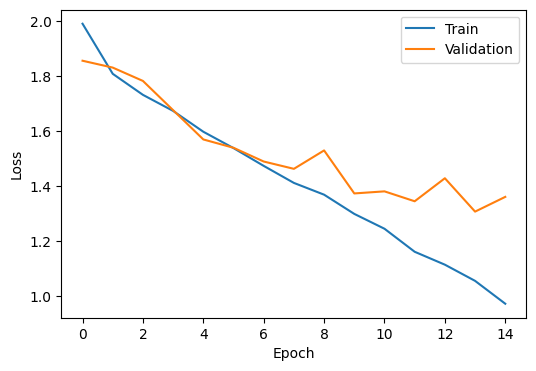

In [ ]:
plot_loss(hist_tr, hist_val)

del model, train_loader, test_loader, hist_tr, hist_val

Assim como na LeNet5, a utilização do early stopping inibiu eficazmente a possibilidade de overfitting.


# Avaliação

Nesta última etapa do nosso pipeline de aprendizado de máquina, vamos avaliar os modelos selecionados para determinar qual é a melhor opção para nossa tarefa. Faremos isso através de três processos:

1. Avaliação usando métricas como precisão, recall e pontuação F1.
2. Análise da matriz de confusão para entender como os modelos estão classificando as instâncias.
3. Análise da curva ROC para avaliar a capacidade discriminativa de cada modelo.

Essas avaliações nos ajudarão a tomar uma decisão informada sobre qual modelo utilizar.

## Funções úteis

In [25]:
# Dicionário auxiliar para passarmos os labels de volta para seus nomes originais
to_name = {
        index: name for index, name in enumerate(unq_labels)
    }

In [26]:
def get_avaliation_pytorch(file, model_name):
    """
        Função responsável por prever os dados de teste das redes neurais em PyTorch para a possível avaliação do nosso modelo.

        Parâmetros:
            file (str): Diretório do modelo.
            model_name (str): Nome do modelo.
        Retorno:
            result: resultados da predição.
            target: valores algo.
    """
    model = torch.load(file)
    
    model.eval()
    result = np.empty(0)
    target = np.empty(0)

    _, _, test_loader = get_train_data(model_name, n_label)

    with torch.no_grad():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)
            y_hat = model(img)
            probs = nn.functional.softmax(y_hat, dim=1)

            _, predicted_classes = torch.max(probs, 1)
            
            result = np.append(result, predicted_classes.cpu().numpy())
            target = np.append(target, label.cpu().numpy())
            
    del test_loader
            
    return result, target

In [27]:
def get_avaliation_joblib(file):
    """
        Função responsável por prever os dados de teste do sklearn para a possível avaliação do nosso modelo.

        Parâmetros:
            file (str): Diretório do modelo.
        Retorno:
            result: resultados da predição.
            target: valores algo.
    """
    model = joblib.load(file)
    
    aux_X, target = to_classic(X_test, y_test)
    
    result = model.predict(aux_X)
    
    return result, target

## Métricas


No primeiro processo de avaliação, iremos nos basear em um conjunto de métricas para compreender o desempenho dos modelos:

1. **Precision Macro**: Média das precisões para cada classe, útil em conjuntos de dados desequilibrados.
2. **Precision Micro**: Precisão agregada considerando todas as classes, útil em conjuntos de dados balanceados.
3. **Recall Macro**: Média das taxas de verdadeiros positivos para cada classe, útil em conjuntos de dados desequilibrados.
4. **Recall Micro**: Taxa de verdadeiros positivos agregada, considerando todas as classes, útil em conjuntos de dados balanceados.
5. **F1 Macro**: Média harmônica das precisões e revocações macro, equilibrada para todas as classes, útil em conjuntos de dados desequilibrados.
6. **F1 Micro**: Média harmônica das precisões e revocações micro, útil em conjuntos de dados balanceados.
7. **Accuracy**: Taxa global de classificações corretas, útil em problemas de classificação balanceados.

Além disso, Optamos pela **F1-Score micro** como métrica principal devido à sua capacidade de fornecer uma medida global do desempenho do modelo em todas as classes, sem favorecer nenhuma em particular. Essa métrica é ideal para conjuntos de dados balanceados, pois calcula a precisão e recall agregados, garantindo uma avaliação abrangente e equitativa do modelo.


In [28]:
def get_metrics(result, target):
    """
        Função responsável por calcular as métricas do resultado do nosso modelo.
        
        Parâmetros:
            result: resultados da predição.
            target: valores algo.
        Retorno:
            lista de métricas
    """
    precision_macro = precision_score(target, result, average='macro')
    precision_micro = precision_score(target, result, average='micro')

    recall_macro = recall_score(target, result, average='macro')
    recall_micro = recall_score(target, result, average='micro')

    f1_macro = f1_score(target, result, average='macro')
    f1_micro = f1_score(target, result, average='micro')

    accuracy = accuracy_score(target, result)
    
    return [precision_macro, precision_micro, recall_macro, recall_micro, f1_macro, f1_micro, accuracy]

In [29]:
columns = ['name', 
           'precision_macro', 
           'precision_micro', 
           'recall_macro', 
           'recall_micro', 
           'f1_macro', 
           'f1_micro', 
           'accuracy']

df_result = pd.DataFrame(columns=columns)


for file in glob.glob('./models/*'):
    model_name, extension = os.path.splitext(file)

    if extension == '.pth':
        result, target = get_avaliation_pytorch(file, model_name[len('./models/model_'):])
    elif extension == '.joblib':
        result, target = get_avaliation_joblib(file)
        
    df_result.loc[df_result.shape[0]] = [model_name[len('./models/model_'):]] + get_metrics(result, target)

df_result

name  precision_macro  precision_micro  recall_macro  \
0               LeNet5         0.512596         0.500000      0.493564   
1           CNN_Custom         0.703963         0.675516      0.681868   
2          CNN_Article         0.612119         0.525074      0.525095   
3  K-Nearest_Neighbors         0.686739         0.675516      0.690379   
4        Decision_Tree         0.515979         0.507375      0.509689   
5        Random_Forest         0.726167         0.691740      0.692119   
6          Naive_Bayes         0.237157         0.272861      0.257760   

   recall_micro  f1_macro  f1_micro  accuracy  
0      0.500000  0.492616  0.500000  0.500000  
1      0.675516  0.690685  0.675516  0.675516  
2      0.525074  0.547754  0.525074  0.525074  
3      0.675516  0.687437  0.675516  0.675516  
4      0.507375  0.511076  0.507375  0.507375  
5      0.691740  0.703302  0.691740  0.691740  
6      0.272861  0.228900  0.272861  0.272861

Após analisar a tabela, fica evidente que o modelo mais promissor é a `Random_forest`, destacando-se por alcançar uma F1-Score micro de $0.691740$. Em seguida, temos a `CNN_Custom`, que obteve uma pontuação de $0.675516$. É importante ressaltar que a `Random_forest` demonstrou um desempenho superior em todas as métricas avaliadas, consolidando sua posição como o modelo mais adequado para nossa tarefa.

**OBS**: Vale salientar que a diferença nos conjuntos de dados pode explicar o baixo desempenho da rede neural no artigo em comparação com nossa análise. Enquanto usamos 3388 imagens distribuídas em 8 classes, o artigo empregou um conjunto de dados maior, com 23876 imagens divididas em 20 classes. Esta disparidade pode ter impactado os resultados, enfatizando a importância da consistência e representatividade dos dados na avaliação do desempenho dos modelos de redes neurais.

## Matriz de confusão

Neste segundo processo vamos realizar uma análise visual mais detalhada dos dados exibindo as matrizes de confusão dos modelos empregados. Deste modo, essa abordagem nos permitirá uma abordagem mais detalhada da distribuição dos resultados por classe, possibilitando identificar padrões e áreas de melhoria de forma mais precisa.

In [30]:
def plot_confusion_matrix(result, target, model_name):
    """
        Função responsável pela plotagem da matriz de confusão.
        
        Parâmetros:
            result: resultados da predição.
            target: valores algo.
    """
    _, ax = plt.subplots(figsize=(6, 6))
    
    ConfusionMatrixDisplay.from_predictions(
        np.asarray(list(map(lambda x: to_name[x], target))),
        np.asarray(list(map(lambda x: to_name[x], result))),
        ax=ax,
        xticks_rotation=90,
        colorbar=True,
    )
    
    plt.title(f'Confusion matrix of model {model_name}')
    plt.show()

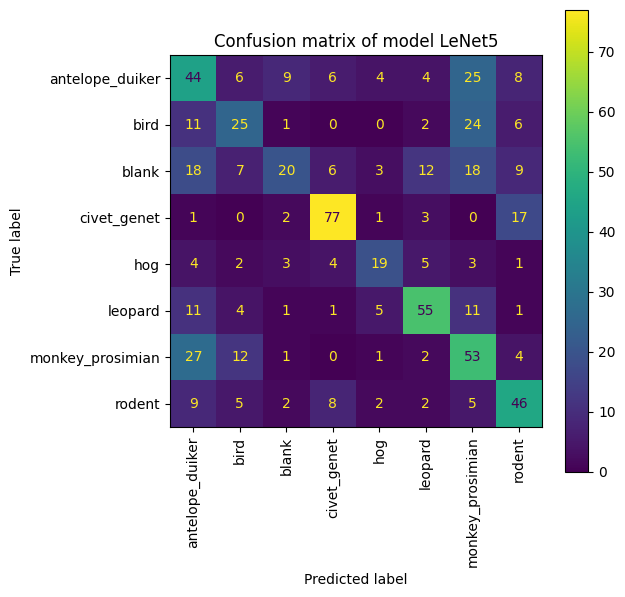

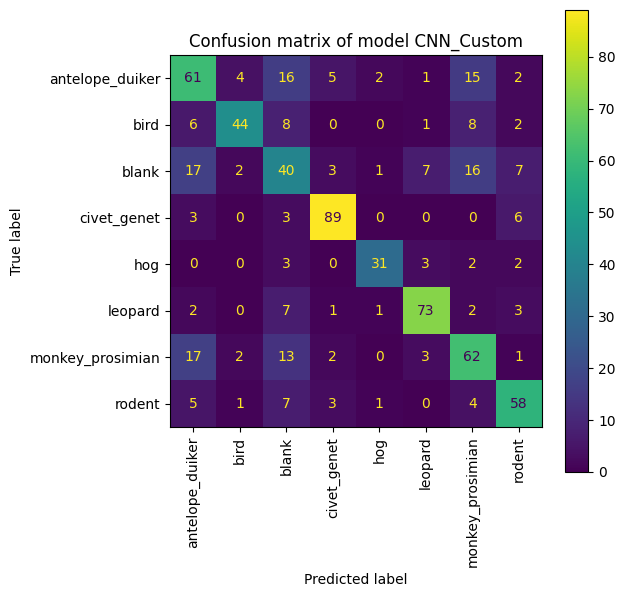

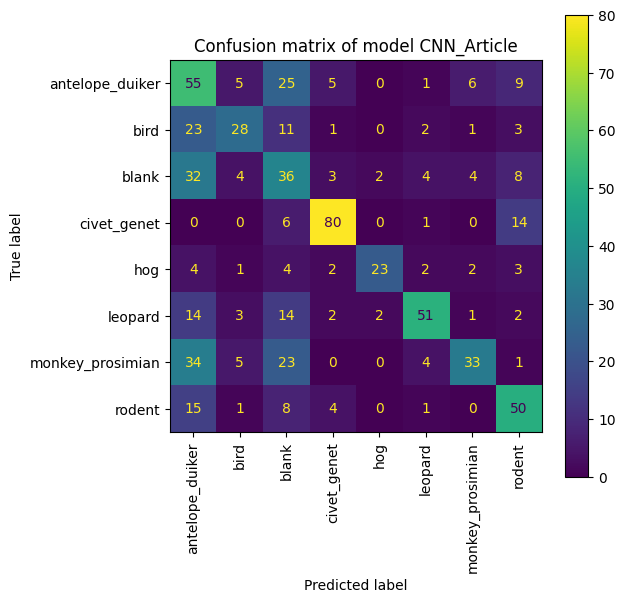

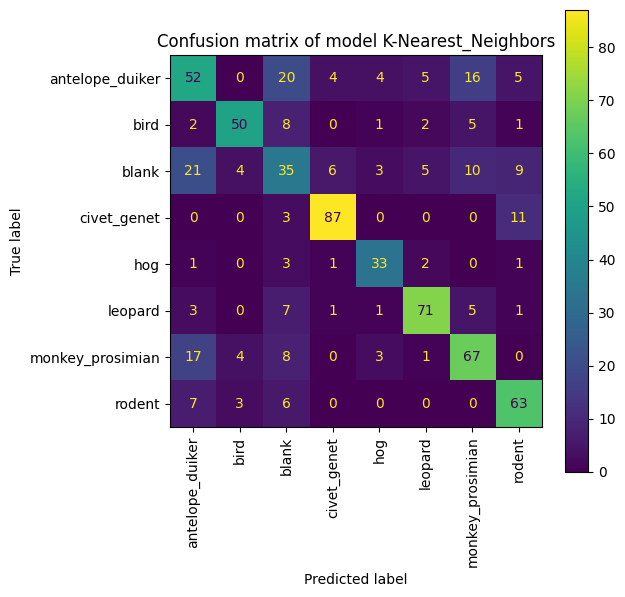

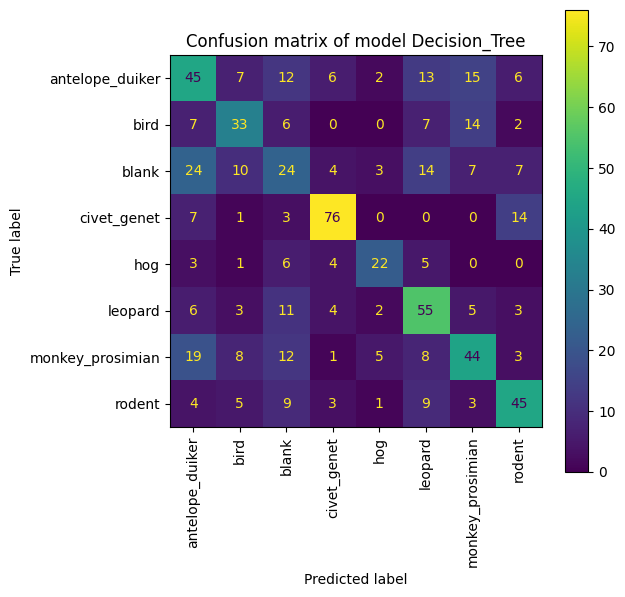

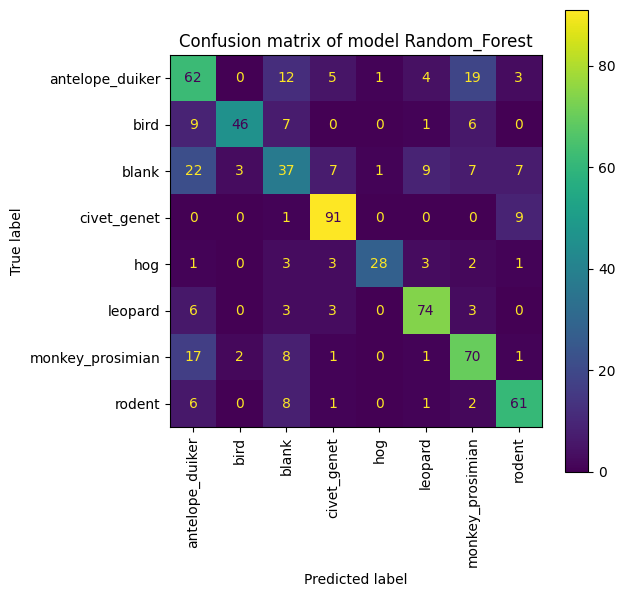

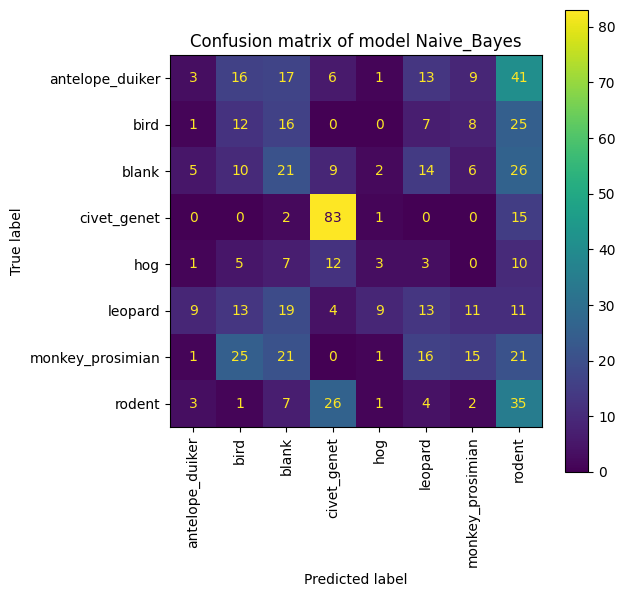

In [31]:
for file in glob.glob('./models/*'):
    model_name, extension = os.path.splitext(file)
    
    if extension == '.pth':
        result, target = get_avaliation_pytorch(file, model_name[len('./models/model_'):])
    elif extension == '.joblib':
        result, target = get_avaliation_joblib(file)
        
    plot_confusion_matrix(result, target, model_name[len('./models/model_'):])

Ao examinar as matrizes de confusão acima, fica evidente que, embora a classe `hog` possua um número menor de exemplos, seus resultados foram consistentemente notáveis em todos os modelos avaliados. Isso sugere que sua baixa incidência não afeta significativamente os resultados. Por outro lado, a classe `blank` apresenta os piores desempenhos, provavelmente devido à sua distribuição mais equilibrada entre as outras classes, o que pode tornar mais desafiador para os modelos distingui-la com precisão.

## Curva ROC

Neste terceiro e último processo,  avançaremos para a análise das curvas ROC para obter resultadoa mais detalhados sobre o desempenho de cada classe. Iremos identificar os modelos que se destacam em cada classe com base nessas curvas, visando discernir quais apresentam os resultados mais promissores. Essa abordagem nos permitirá não apenas compreender melhor o desempenho individual de cada modelo, mas também determinar qual deles oferece o melhor desempenho globalmente.

In [32]:
def plot_roc(result, target, model_name):
    """
        Função responsável pela plotagem da curva ROC.
        
        Parâmetros:
            result: resultados da predição.
            target: valores algo.
            model_name: nome do modelo.
    """
    y_true = np.asarray(list(map(lambda x: to_name[x], target)))
    y_pred = np.asarray(list(map(lambda x: to_name[x], result)))

    classes = np.asarray(list(map(lambda x: to_name[x], np.unique(target))))
    y_true_bin = label_binarize(y_true, classes=classes)
    y_pred_bin = label_binarize(y_pred, classes=classes)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 5))
    colors = cycle(['#00FFFF', '#FF8C00', '#6495ED', '#228B22', '#DC143C', '#FFD700', '#9370DB', '#FF6347'])
    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Multiclass of model {model_name}')
    plt.legend(loc="lower right")
    plt.show()

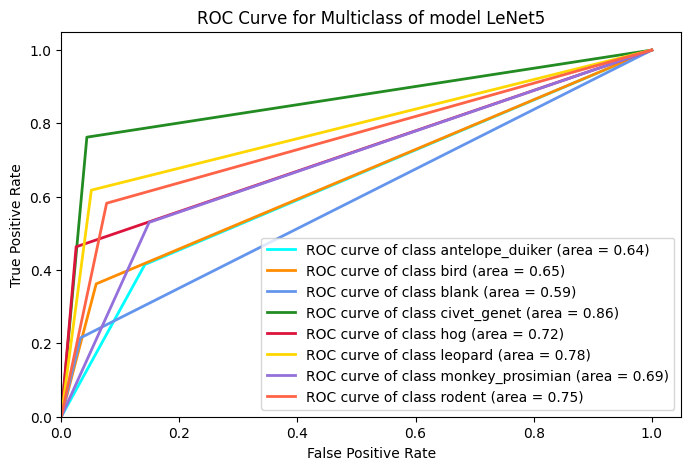

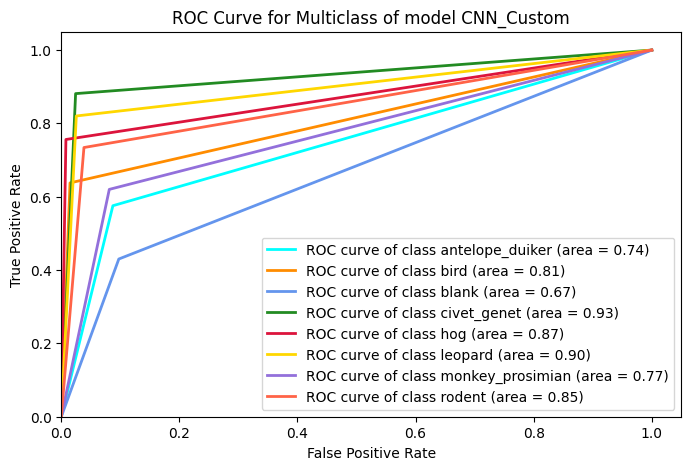

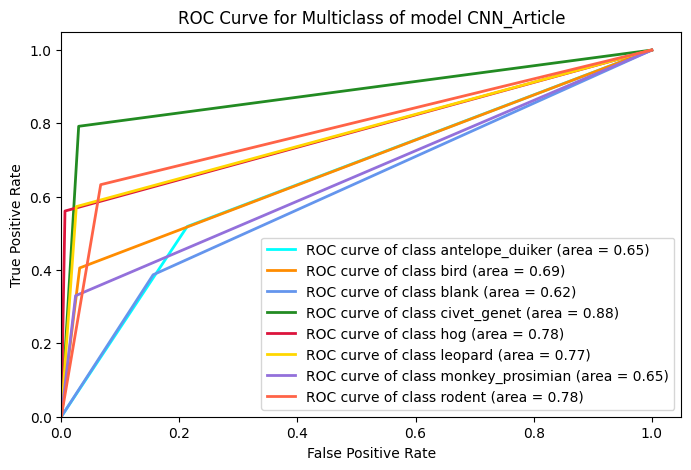

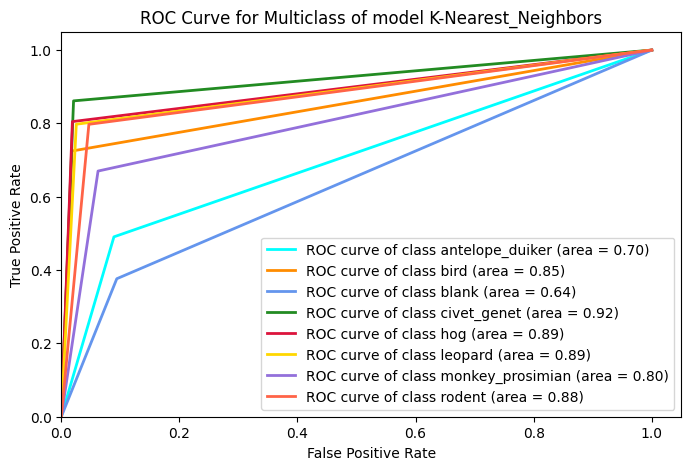

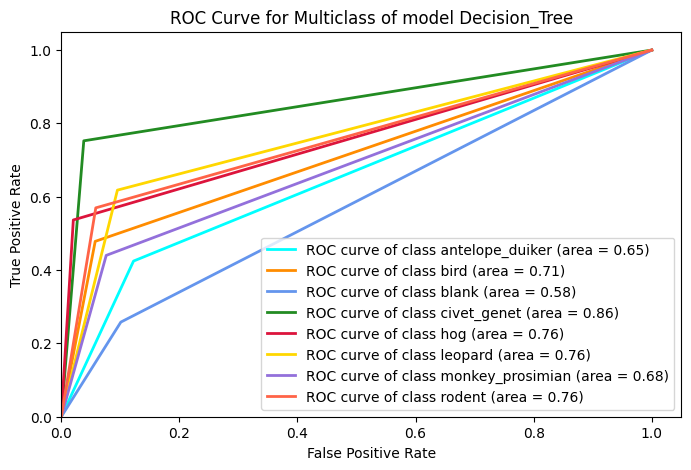

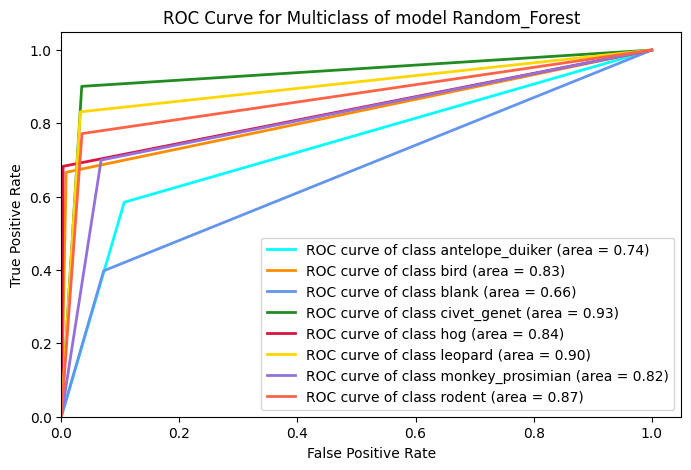

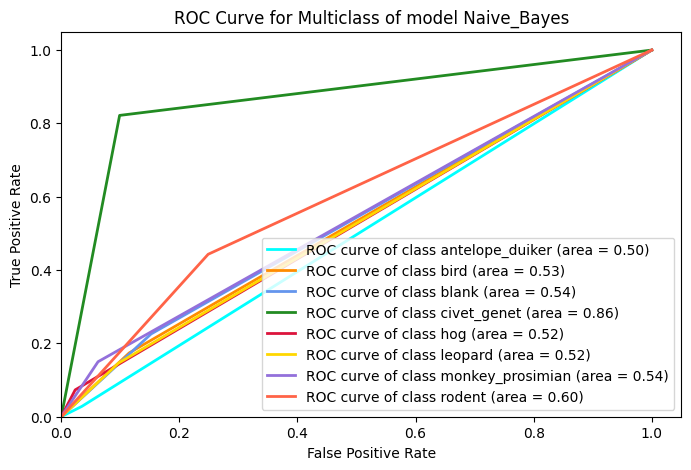

In [33]:
for file in glob.glob('./models/*'):
    model_name, extension = os.path.splitext(file)
    
    if extension == '.pth':
        result, target = get_avaliation_pytorch(file, model_name[len('./models/model_'):])
    elif extension == '.joblib':
        result, target = get_avaliation_joblib(file)
        
    plot_roc(result, target, model_name[len('./models/model_'):])

Por fim, iremos para o resultados da curva ROC:

1. `antelope_duiker`: `Random_Forest` e `CNN_Custom` ($0.74$)
2. `bird`: `KNN` ($0.85$)
3. `blank`: `CNN_Custom` ($0.67$)
4. `civet_genet`: `Random_Forest` e `CNN_Custom` ($0.93$)
5. `hog`: `KNN` ($0.89$)
6. `leopard`: `Random_Forest` e `CNN_Custom` ($0.90$)
7. `monkey_prosimian`: `Random_Forest` ($0.82$) 
8. `rodent`: `KNN` ($0.88$) 

Em resumo,  os modelos Random Forest e CNN Custom mostraram um desempenho consistente e elevado em várias categorias, especialmente em antelope_duiker, civet_genet e leopard. O modelo KNN também se destacou nas categorias bird, hog e rodent.

# Conclusão

---

Podemos concluir que a classificação de animais a partir de um conjunto de imagens é viável, e isso nos incentiva a prosseguir com nosso projeto. O modelo `Random_Forest` se destacou, alcançando uma F1-Score Macro de $0.691740$. No entanto, como próximos passos, seria benéfico expandir nosso conjunto de dados e testar novos dados para garantir a robustez do modelo. Infelizmente, devido às limitações de hardware, não foi possível realizar essa etapa neste momento. Apesar disso, essa experiência fortaleceu nosso entendimento do pipeline de aprendizado de máquina e nos preparou para enfrentar desafios futuros com maior confiança.